`April 4, 2022`

### **Imbalanced Classification Exercise**

#### **Use 'stroke' dataset.**

1. Explore the data first.
2. Do data preprocessing as needed (use pipeline(s)).
3. Target: 'stroke'; Features: Your consideration.
4. Define the evaluation metric that you will use.
5. Use logistic regression, KNN, and decision tree algorithms and find the optimum model for this case.
6. Do imbalanced data treatment with a pipeline (you can compare several methods and choose the optimum one).
7. Tune the model benchmark (use GridSearch if possible), then compare the model performance before and after hyperparameter tuning.
8. Interpret the result by displaying the confusion matrix and explaining each quadrant.


### **Feature Information**

|   **Feature**     |       **Description**       |
|-------------------|-----------------------------|
id                  | Unique identifier
gender              | 'Male', 'Female' or 'Other'
age                 | Age of the patient
hypertension        | 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
heart_disease       | 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
ever_married        | 'No' or 'Yes'
work_type           | 'children', 'Govt_jov', 'Never_worked', 'Private' or 'Self-employed'
Residence_type      | 'Rural' or 'Urban'
avg_glucose_level   | Average glucose level in blood
bmi                 | Body mass index
smoking_status      | 'formerly smoked', 'never smoked', 'smokes' or 'Unknown'
stroke              | 1 if the patient had a stroke or 0 if not. Note: 'Unknown' in smoking_status means that the information is unavailable for this patient

### **Import libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

### **Explore the data**

In [2]:
df = pd.read_csv('stroke.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# Chekc missing values.
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# Check duplicates.
df[df.duplicated()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [6]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [7]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in gender:  3
Unique values:  ['Male' 'Female' 'Other']

Total unique values in ever_married:  2
Unique values:  ['Yes' 'No']

Total unique values in work_type:  5
Unique values:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Total unique values in Residence_type:  2
Unique values:  ['Urban' 'Rural']

Total unique values in smoking_status:  4
Unique values:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [8]:
for i in cat_features:
    print(df[i].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [9]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['stroke']))]
num_features

['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

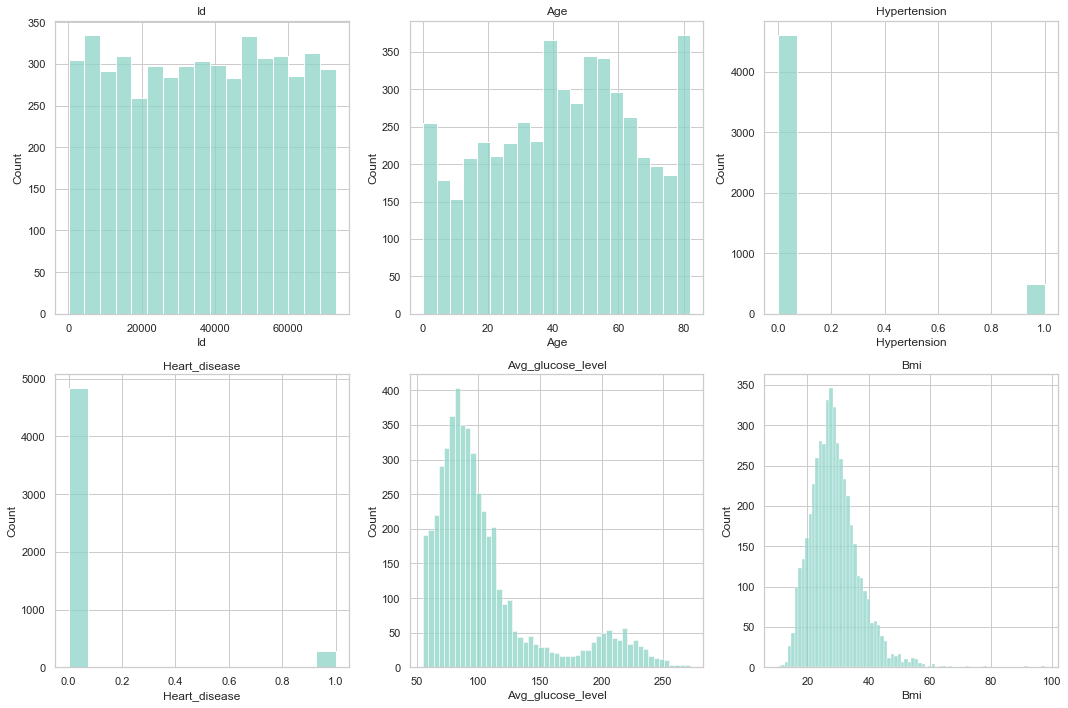

In [10]:
plt.figure(figsize=(15, 10), facecolor='white')
sns.set(style='whitegrid', palette='Set3')
plotnumber = 1

for feature in num_features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.histplot(x=feature, data = df)
    plt.xlabel(feature.capitalize())
    plt.title(feature.capitalize())
    plt.tight_layout()
    plotnumber += 1;

In [11]:
# Check skewness.
for i in num_features:
    print(i, df[i].skew())

id -0.019912979190701046
age -0.1370593225984694
hypertension 2.7153916581245294
heart_disease 3.947243966661894
avg_glucose_level 1.5722838665030459
bmi 1.0553402052962912


### **Preprocess the data**

`Preprocessing schemas`

- Change the columns order.
- Drop 'id' column.
- Drop 'Other' in 'gender' column.
- Impute missing values in 'bmi' column with IterativeImputer.
- Encode all categorical features with OneHotEncoder.
- Scale the numerical data with RobustScaler.
- Imbalanced data treatment with SMOTENC.

In [12]:
num_features2 = [feature for feature in df.columns if ((df[feature].dtypes != 'O'))]
num_features2

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [13]:
# Change the columns order
cols = cat_features  + num_features2
df = df[cols]
df.head()

,gender,ever_married,work_type,Residence_type,smoking_status,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,Male,Yes,Private,Urban,formerly smoked,9046,67.0,0,1,228.69,36.6,1
1,Female,Yes,Self-employed,Rural,never smoked,51676,61.0,0,0,202.21,NaN,1
2,Male,Yes,Private,Rural,never smoked,31112,80.0,0,1,105.92,32.5,1
3,Female,Yes,Private,Urban,smokes,60182,49.0,0,0,171.23,34.4,1
4,Female,Yes,Self-employed,Rural,never smoked,1665,79.0,1,0,174.12,24.0,1


In [14]:
df[df['gender'] == 'Other']

,gender,ever_married,work_type,Residence_type,smoking_status,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
3116,Other,No,Private,Rural,formerly smoked,56156,26.0,0,0,143.33,22.4,0


In [15]:
# Drop 'other' in gender
df = df.drop(df.index[3116])
df = df.reset_index()

In [16]:
df = df.drop(['index', 'id'], axis=1)
df

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,Male,Yes,Private,Urban,formerly smoked,67.0,0,1,228.69,36.6,1
1,Female,Yes,Self-employed,Rural,never smoked,61.0,0,0,202.21,NaN,1
2,Male,Yes,Private,Rural,never smoked,80.0,0,1,105.92,32.5,1
3,Female,Yes,Private,Urban,smokes,49.0,0,0,171.23,34.4,1
4,Female,Yes,Self-employed,Rural,never smoked,79.0,1,0,174.12,24.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,Yes,Private,Urban,never smoked,80.0,1,0,83.75,NaN,0
5105,Female,Yes,Self-employed,Urban,never smoked,81.0,0,0,125.20,40.0,0
5106,Female,Yes,Self-employed,Rural,never smoked,35.0,0,0,82.99,30.6,0
5107,Male,Yes,Private,Rural,formerly smoked,51.0,0,0,166.29,25.6,0


In [17]:
df.corr()['stroke']

age                  0.245239
hypertension         0.127891
heart_disease        0.134905
avg_glucose_level    0.131991
bmi                  0.042341
stroke               1.000000
Name: stroke, dtype: float64

In [18]:
filtering = df.filter(['gender','heart_disease','hypertension'])
suffer_gender = filtering.groupby('gender').count().reset_index()
suffer_gender

,gender,heart_disease,hypertension
0,Female,2994,2994
1,Male,2115,2115


In [19]:
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [20]:
df['stroke'].value_counts(True)*100

0    95.126248
1     4.873752
Name: stroke, dtype: float64

**Imputing missing values**

In [21]:
imp_iter = IterativeImputer(max_iter=50, random_state=42)
df[['bmi']] = imp_iter.fit_transform(df[['bmi']])

In [22]:
df['bmi'].isna().sum()

0

In [23]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'), ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']),
    ('scaler', RobustScaler(), ['age', 'avg_glucose_level', 'bmi'])
],  remainder='passthrough')

### **Define X and y**

In [24]:
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

### **Data Splitting**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 42
)

In [26]:
# Fit and transform only to the train set.
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

### **Model benchmark**

In [27]:
X_train

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,bmi
845,Female,Yes,Private,Urban,never smoked,48.0,0,0,69.21,33.1
3744,Female,No,Private,Urban,never smoked,29.0,0,0,84.19,21.2
4183,Female,Yes,Private,Rural,never smoked,35.0,0,0,119.40,22.9
3409,Male,Yes,Private,Rural,never smoked,38.0,0,0,108.68,32.7
284,Male,No,Govt_job,Urban,Unknown,14.0,0,0,82.34,31.6
...,...,...,...,...,...,...,...,...,...,...
1434,Female,Yes,Private,Urban,formerly smoked,45.0,0,0,92.86,35.1
461,Female,No,children,Rural,Unknown,16.0,0,0,113.47,19.5
1052,Female,Yes,Private,Rural,formerly smoked,61.0,0,0,78.65,36.2
1757,Male,Yes,Private,Urban,Unknown,31.0,0,0,74.05,26.0


In [28]:
# Find the best k.
k = range(1, 30, 2)
testing_accuracies = []
training_accuracies = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_prep, y_train)

    y_predict_train = knn.predict(X_train_prep)
    training_accuracies.append(accuracy_score(y_train, y_predict_train))

    y_predict_test = knn.predict(X_test_prep)
    acc_score = accuracy_score(y_test, y_predict_test)
    testing_accuracies.append(acc_score)

    if score < acc_score:
        score = acc_score
        best_k = i

    print(i, score)

1 0.9148727984344422
3 0.9471624266144814
5 0.9471624266144814
7 0.949119373776908
9 0.949119373776908
11 0.9510763209393346
13 0.9510763209393346
15 0.9510763209393346
17 0.9510763209393346
19 0.9510763209393346
21 0.9510763209393346
23 0.9510763209393346
25 0.9510763209393346
27 0.9510763209393346
29 0.9510763209393346


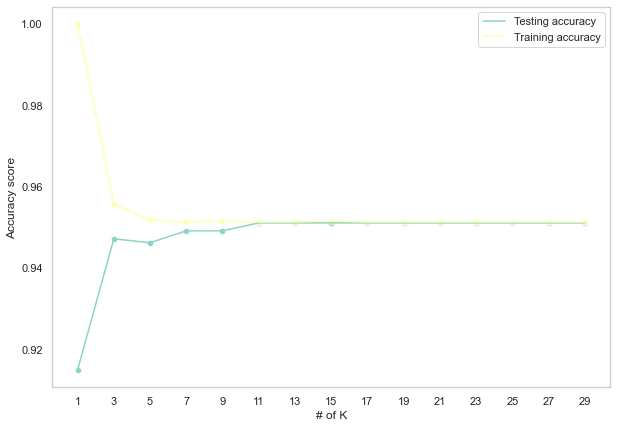

In [29]:
# Plot the accuracies result.
plt.figure(figsize=(10, 7))
sns.lineplot(k, testing_accuracies)
sns.scatterplot(k, testing_accuracies)
sns.lineplot(k, training_accuracies)
sns.scatterplot(k, training_accuracies)
plt.legend(['Testing accuracy', 'Training accuracy'])
plt.xlabel('# of K')
plt.ylabel('Accuracy score')
plt.xticks(list(k))
plt.grid();

In [30]:
# Define models
knn = KNeighborsClassifier(n_neighbors=13)
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)
logreg = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

# Define imbalanced treatment methods
models = [knn, tree, logreg]
score = []
mean_score = []
std_score= []

for i in models:
    smotenc = SMOTENC(categorical_features=np.array(range(0, 5)), random_state=42)
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('balancing', smotenc),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1', error_score='raise')
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

In [31]:
pd.DataFrame({
    'Model':['knn', 'tree', 'logreg'],
    'F1 score mean':mean_score,
    'F1 score std':std_score
})

,Model,F1 score mean,F1 score std
0,knn,0.184574,0.023651
1,tree,0.199798,0.011806
2,logreg,0.216281,0.015006


**`Logistic regression model has the highest recall mean and the most stable model compared to the others. 
Therefore, we choose this model as the model benchmark and will tune its hyperparameter to yield better performance.`**

### **Tuning the model benchmark**

In [44]:
# Create the algorithm chains
smotenc = SMOTENC(categorical_features=np.array(range(0, 5)), random_state=42)
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
estimator = Pipeline([('preprocessing', transformer), ('balancing', smotenc), ('clf', model)])

# Hyperparameter space
hyperparam_space = {
    'clf__C':[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'clf__solver':['liblinear', 'newton-cg'],
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__class_weight': ['balanced', 'weight']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits=5)

# Hyperparameter tuning
grid_search = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    return_train_score = True,
    n_jobs = -1 # use all cores
)

In [45]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'Residence_type',
                                                                          'smoking_status']),
                                                                        

In [34]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__penalty,param_clf__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
55,1.012269,0.201950,0.021255,0.008888,0.01,weight,l2,newton-cg,"{'clf__C': 0.01, 'clf__class_weight': 'weight'...",0.201780,...,0.221962,0.020976,1,0.232852,0.228471,0.233010,0.224893,0.233216,0.230488,0.003309
49,0.965842,0.129115,0.030943,0.012408,0.01,balanced,l2,newton-cg,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",0.201780,...,0.221962,0.020976,1,0.232852,0.228471,0.233010,0.224893,0.233216,0.230488,0.003309
38,1.132611,0.203378,0.031903,0.015255,0.1,balanced,l1,liblinear,"{'clf__C': 0.1, 'clf__class_weight': 'balanced...",0.211838,...,0.221007,0.015792,3,0.231267,0.227314,0.229630,0.224014,0.242647,0.230975,0.006324
50,1.037635,0.228702,0.025332,0.008516,0.01,balanced,l1,liblinear,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",0.209632,...,0.220906,0.015496,4,0.215000,0.210440,0.223717,0.215909,0.231933,0.219400,0.007583
48,1.033628,0.144112,0.017194,0.003069,0.01,balanced,l2,liblinear,"{'clf__C': 0.01, 'clf__class_weight': 'balance...",0.193732,...,0.219435,0.022110,5,0.231561,0.221277,0.227698,0.221671,0.235593,0.227560,0.005563


In [35]:
print('Best score:', grid_search.best_score_)
print('Best params:', grid_search.best_params_)

Best score: 0.2219617351622934
Best params: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}


### **Before & after tuning of logistic regression model**

#### **Before**

In [37]:
smotenc = SMOTENC(categorical_features=np.array(range(0, 5)), random_state=42)
model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)

estimator = Pipeline([('preprocessing', transformer), ('balancing', smotenc), ('clf', model)])

estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.13      0.78      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.74      0.81      1022



#### **After**

In [38]:
grid_search.best_estimator_.fit(X_train, y_train)
y_pred_tuning = grid_search.best_estimator_.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred_tuning))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.13      0.78      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.75      0.53      1022
weighted avg       0.94      0.73      0.80      1022



`Confusion matrix plot`

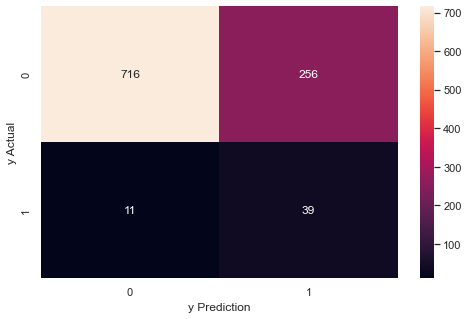

In [40]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediction')
plt.ylabel('y Actual');

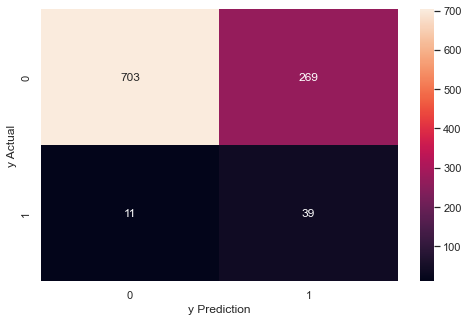

In [41]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediction')
plt.ylabel('y Actual');

### **Interpretation & Conclusion**

TP: The model predicts the patients who suffer a stroke and actually does (39).<br>
FP: The model predicts the patients who suffer a stroke but actually does not (269).
<br><br>
TN: The model predicts the patients who do not suffer a stroke and actually does not (703).<br>
FN: The model predicts the patients who do not suffer a stroke but actually does (11).
<br><br>
In this case, FP and FP are equally important because false positives may lead people to get unnecessary treatment. On the other hand, false negatives are a flaw in diagnosis and may cause a severe problem if not handled immediately.

There is no significant difference between the results of before and after tuning. The precision score is so low cause the f1 score drops significantly (besides recall score is quite good). Since the number of positive class samples is too low, the resampling method that we have done can't overcome the main problem. Therefore, we may try other methods that may work on this dataset. 